In [1]:
"""author: Vetivert? 💐 
created: 05/06/2025 @ 21:58:06"""

'author: Vetivert? 💐 \ncreated: 05/06/2025 @ 21:58:06'

In [78]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
# from src.utils.models import *
from src.utils.functions import *

# FUNCTIONS

In [32]:
def distribution_plot(df_x, x_name: str, data_name:str):
    plt.subplots(figsize=(10, 6))
    x_3 = df_x.loc[df_x['Diagnosis'] == 3, x_name]
    x_2 = df_x.loc[df_x['Diagnosis'] == 2, x_name]
    x_1 = df_x.loc[df_x['Diagnosis'] == 1, x_name]
    y_3 = np.random.rand(x_3.shape[0])
    y_2 = np.random.rand(x_2.shape[0])
    y_1 = np.random.rand(x_1.shape[0])

    # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

    # ax[0].scatter(x_3, np.random.rand(x_3.shape[0]) * 10, color='red', alpha=0.75)
    # ax[0].scatter(x_2, np.random.rand(x_2.shape[0]) * 10, color='navy', alpha=0.75)
    # ax[0].scatter(x_1, np.random.rand(x_1.shape[0]) * 10, color='green', alpha=0.75)
    # ax[0].set_xlabel(x_name + ' Values')
    # ax[0].set_xlim(0, np.max(df_x[x_name]) + 1)
    # ax[0].set_ylim(-0.25, 10.25)
    # ax[0].set_yticks([])

    plt.scatter(x_3, [4/80] * (y_3 + 1), label = 'Diagnosis 3', color='red', alpha=0.65)
    plt.scatter(x_2, [2/80] * (y_2 + 1), label = 'Diagnosis 2',color='navy', alpha=0.65)
    plt.scatter(x_1, [1/80] * (y_1 + 1), label = 'Diagnosis 1',color='green', alpha=0.65)
    plt.vlines(np.max(x_3), 0, (4/80) * (y_3[np.argmax(x_3)]+1), label = f'{np.max(x_3)}: max value of Diagnosis 3', color='red', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_3), 0, (4/80) * (y_3[np.argmin(x_3)]+1), label = f'{np.min(x_3)}: min value of Diagnosis 3', color='red', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_2), 0, (2/80) * (y_2[np.argmax(x_2)]+1), label = f'{np.max(x_2)}: max value of Diagnosis 2', color='navy', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_2), 0, (2/80) * (y_2[np.argmin(x_2)]+1), label = f'{np.min(x_2)}: min value of Diagnosis 2', color='navy', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_1), 0, (1/80) * (y_1[np.argmax(x_1)]+1), label = f'{np.max(x_1)}: max value of Diagnosis 1', color='green', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_1), 0, (1/80) * (y_1[np.argmin(x_1)]+1), label = f'{np.min(x_1)}: min value of Diagnosis 1', color='green', alpha=0.65, linestyle=":")
    sns.kdeplot(x_3, color='red')
    sns.kdeplot(x_2, color='navy')
    sns.kdeplot(x_1, color='green')
    plt.legend()
    # plt.xlim(-10, np.max(df_x[x_name]) + 100)
    plt.yticks([])
    plt.title(x_name + ' Distribution by Diagnosis ' + data_name, fontsize=14)
    # plt.colorbar(ticks = [1,2,3], values = [1,2,3], label='Diagnosis')

    # fig.colorbar(cmap=['green','navy','red'], ticks = [1,2,3], values = [1,2,3], ax = ax[0], label='Diagnosis')
    # fig.suptitle(x_name + ' Distribution by Diagnosis', fontsize=16)
    plt.show()

# LOAD DATA 2017 + 2019

In [2]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)
df = df.replace('(17/9)3.7', 3.7)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])



# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)

# df = df.copy()


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': np.float64(56.4), '2': np.float64(39.66), '3': np.float64(3.94)}


/tmp/ipykernel_54660/1674654194.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('8(nặng xin về)', 8)
/tmp/ipykernel_54660/1674654194.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
/tmp/ipykernel_54660/1674654194.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

# LOAD DATA 2025

In [17]:
df_2025 = pd.read_csv(DATA_PATH_2025, sep=",", header=0, nrows = 125) #separator is ;

In [18]:
# df_2025.dtypes
df_2025

,STT,Số bệnh án,Họ & tên,Năm sinh,Tuổi,Giới tính,Chẩn đoán,Cân nặng,Chiều cao,BMI,...,CRE,BILI-TP,BILI-TT,ALBUMUN,Glucose,MaBenhpham,IgG,IgM,KN B19,NestedPCR
0,1,22043345,Võ Minh Trọng,2003,19,1,Sốt xuất huyết Dengue N3 có DHCB/ Rối loạn điệ...,57.0,168.0,20.195578,...,80.7,7.9,2.4,34.1,NaN,DEN1,0,0,0,0
1,2,22042989,Trương Văn Đức,1999,23,1,Sốt xuất huyết Dengue/ Viêm loét dạ dày- tá tr...,90.0,167.0,32.270788,...,84.7,8.2,1.9,NaN,6.0,DEN2,0,0,0,0
2,3,22043439,Tăng Thế Anh Hoàng,2002,20,1,Sốt xuất huyết Dengue/ Viêm gan nhiễm độc/ viê...,70.0,170.0,24.221453,...,NaN,NaN,NaN,NaN,NaN,DEN3,0,0,0,0
3,4,22042233,Đặng Thái Phong,1999,23,1,Sốt nhiễm khuẩn/ Nhiễm khuẩn huyết đường vào t...,53.0,174.0,17.505615,...,124.6,22.5,10.4,NaN,5.4,DEN4,0,0,0,0
4,5,22043566,Phạm Mạnh Cường,1984,38,1,Sốt xuất huyết Dengue có DHCB/ Viêm dạ dày - t...,60.0,170.0,20.761246,...,130.5,19.2,4.2,NaN,NaN,DEN5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,121,22058520,Phan Thị Phượng,1985,37,2,Sốt xuất huyết Dengue có DHCB/Tăng men gan,54.0,155.0,22.476587,...,NaN,NaN,NaN,NaN,NaN,DEN121,1,0,0,0
121,122,22058492,Lê Thị Danh,1984,38,2,Sốt xuất huyết Dengue có DHCB,46.0,153.0,19.650562,...,77.2,7.4,2.0,30.9,6.6,DEN122,0,0,0,0
122,123,22058741,Nguyễn Thị Thu,1975,47,2,Sốt xuất huyết Dengue/ Viêm gan nhiễm độc/ rối...,NaN,NaN,NaN,...,78.8,12.1,3.5,32.3,4.3,DEN123,0,0,0,0
123,124,22058461,Nguyễn Thị Hạnh,1971,51,2,Sốt siêu vi/viêm loét DD-TT/ trào ngược dạ dày...,50.0,150.0,22.222222,...,69.9,6.1,0.8,36.4,9.6,DEN124,0,0,0,0


In [74]:
df_test = df_2025.loc[:, 'Mạch':'ALT'].copy()

In [75]:
df_test

,Mạch,THA,HATT,HATTr,WBC,NEU,%NEU,LYM,%LYM,RBC,HGB,HCT,PLT,AST,ALT
0,98.0,0,118.0,73.0,2.9,2.1,72.0,0.5,16.8,5.17,15.2,43.9,76,120.5,45.9
1,114.0,0,120.0,70.0,2.2,1.1,49.0,0.6,26.7,5.29,15.2,44.9,62,401.1,263.3
2,104.0,0,112.0,76.0,4.6,3.8,82.4,0.2,4.7,4.41,13.2,39.3,144,16.8,15.5
3,108.0,0,88.0,56.0,6.8,6.3,93.5,0.2,2.8,4.22,12.6,38.1,118,48.9,29.7
4,80.0,0,120.0,70.0,6.6,1.3,19.2,2.1,32.1,5.31,15.9,46.9,14,66.2,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,89.0,0,100.0,60.0,3.3,1.1,32.8,1.4,42.3,4.95,14.0,42.3,27,NaN,NaN
121,80.0,0,110.0,70.0,3.6,1.7,46.9,1.0,27.7,5.85,16.3,49.6,8,78.5,41.3
122,NaN,0,NaN,NaN,3.1,1.7,54.5,0.6,26.1,4.34,12.9,38.4,28,214.4,125.2
123,89.0,0,101.0,70.0,3.5,1.6,45.6,1.5,43.1,4.14,11.7,35.4,161,23.8,24.9


# LOAD DATA SAMPLES

In [56]:
df_samples = pd.read_csv(DATA_PATH_SAMPLES, sep=",", header=0, nrows = 279) #separator is ;

df_samples.drop(['Oder No', 'Age', 'Samp No', 'Fiver', 'bleeding place'], inplace=True, axis=1)
df_samples = df_samples.replace('110,0', 111.0)
df_samples['Vomiting'] = df_samples['Vomiting'].fillna(0)
df_samples["PLT"] = pd.to_numeric(df_samples["PLT"])

df_samples = df_samples.dropna() #remove NA elements in AST/ALT



In [57]:
# df_samples
df_samples.dtypes

# df_samples.isnull().sum()


Gende               int64
Diagnosis           int64
day of symtoms      int64
GOT               float64
GPT               float64
RBC               float64
WBC               float64
PLT               float64
HCT               float64
NS1               float64
IgG               float64
IgM               float64
bleeding            int64
Vomiting          float64
headache            int64
bodyache            int64
dtype: object

In [60]:
# Sample data
X = df_samples.drop(columns=['Diagnosis']).values
Y = df_samples['Diagnosis'].values.ravel()

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

rf_model = RandomForestClassifier()

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Cross-validated accuracy scores: [0.75, 0.875, 0.625, 0.7916666666666666, 0.625, 0.7916666666666666, 0.6666666666666666, 0.7083333333333334, 0.7083333333333334, 0.782608695652174]
Mean accuracy: 0.7324


In [61]:
param_grid = {'n_estimators': [50, 75, 100, 200], 'max_depth': [3, 7, 9, 15], 'min_samples_split': [2, 5, 10, 12 ], 'min_samples_leaf': [1, 2, 4,6,8], 'max_features': ['sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.7661231884057972


In [73]:
import joblib

# Save the model
joblib.dump(grid.best_estimator_, 'RF_2025_076.pkl')

['RF_2025_076.pkl']

Index(['Gende', 'day of symtoms', 'GOT', 'GPT', 'RBC', 'WBC', 'PLT', 'HCT',
       'NS1', 'IgG', 'IgM', 'bleeding', 'Vomiting', 'headache', 'bodyache'],
      dtype='object')


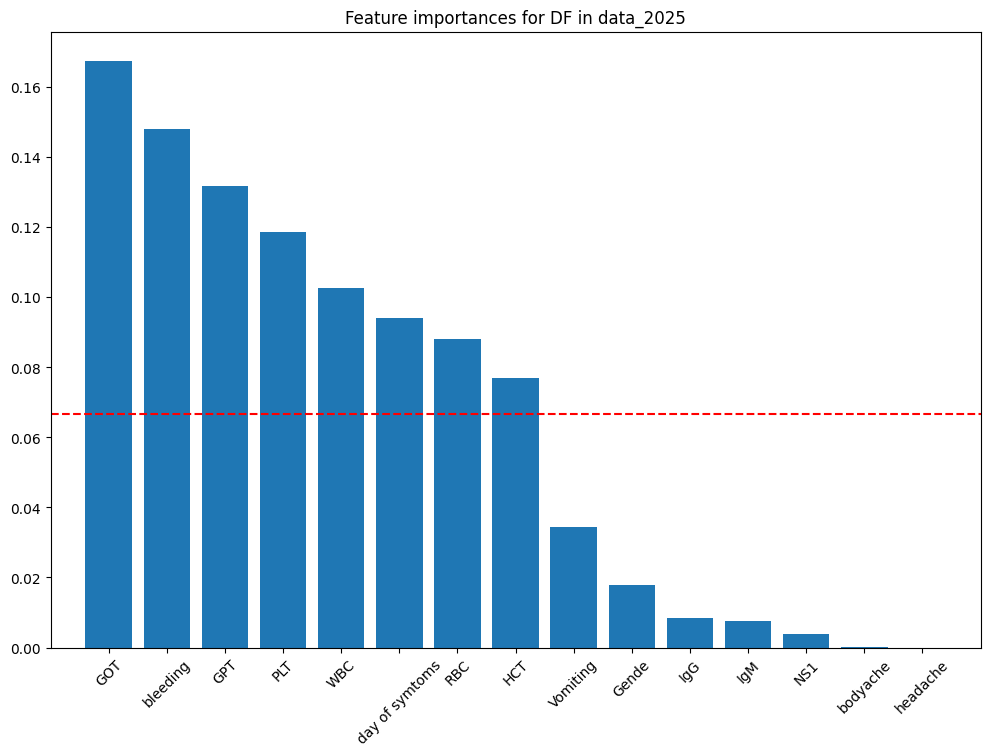

In [69]:
# Classification report
# print("\nClassification Report:")
# print(classification_report(YA_test, YA_pred))

# uniques, counts = np.unique(YA_pred, return_counts=True)
# print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(YA_pred), 2))))

# Plotting feature importances
features = df_samples.drop(columns=['Diagnosis']).columns
print(features)
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances for DF in data_2025")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

In [76]:

x1_train, x1_test, y1_train, y1_test = train_test_split(X, Y, \
                                                    test_size=0.2, random_state=17, stratify=Y)
x1_features = df_samples.drop(columns=['Diagnosis']).columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (191, 15) y1_train shape:  (191,)
x1_test shape:  (48, 15) y1_test shape:  (48,)
percentage of classes:  {np.int64(1): np.float64(62.5), np.int64(2): np.float64(35.42), np.int64(3): np.float64(2.08)}


In [80]:
# Convert class labels from 1-based (1,2,3) to 0-based (0,1,2) for XGBoost
y1_train_0based = y1_train - 1
y1_test_0based = y1_test - 1

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    eval_metric='error'
)

xgb_model.fit(x1_train, y1_train_0based)

# When predicting later, remember to add +1 to convert back to original classes

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

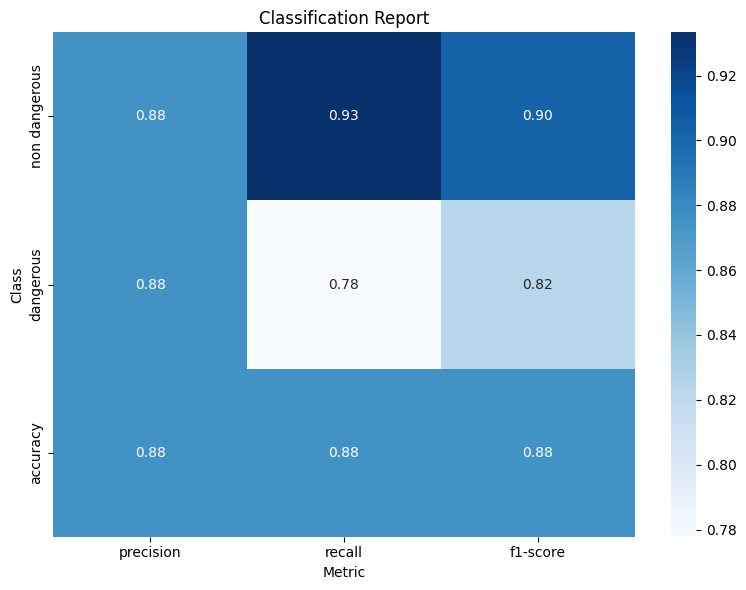

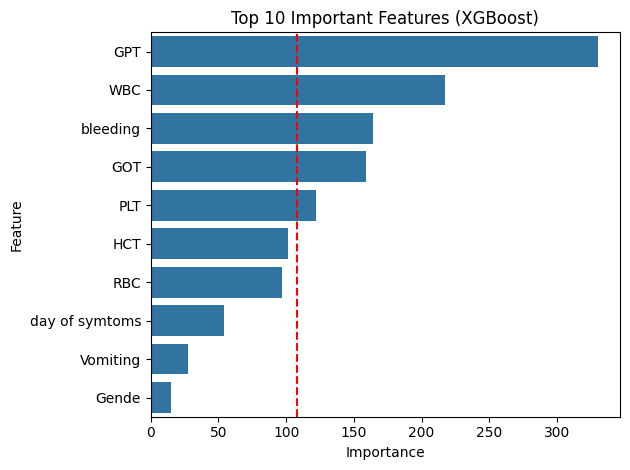

In [82]:
evaluate(xgb_model, x1_test, y1_test_0based)
gain_importances_df = plot_feature_importance(xgb_model, x1_features, importance_type='total_gain')

In [83]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1, 0.2]
}

# search = RandomizedSearchCV(xgb.XGBClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy', verbose=1)
search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x1_train, y1_train_0based)
print("Best parameters:", search.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}


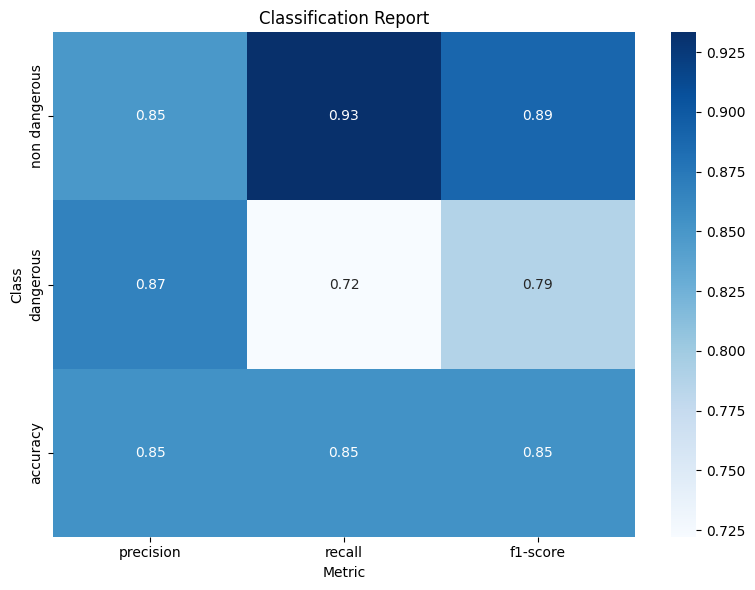

{'accuracy': 0.8541666666666666,
 'precision': 0.8666666666666667,
 'recall': 0.7222222222222222,
 'f1_score': 0.7878787878787878,
 'roc_auc': np.float64(0.8444444444444444)}

In [84]:
xgb_grid = search.best_estimator_
evaluate(xgb_grid, x1_test, y1_test_0based)

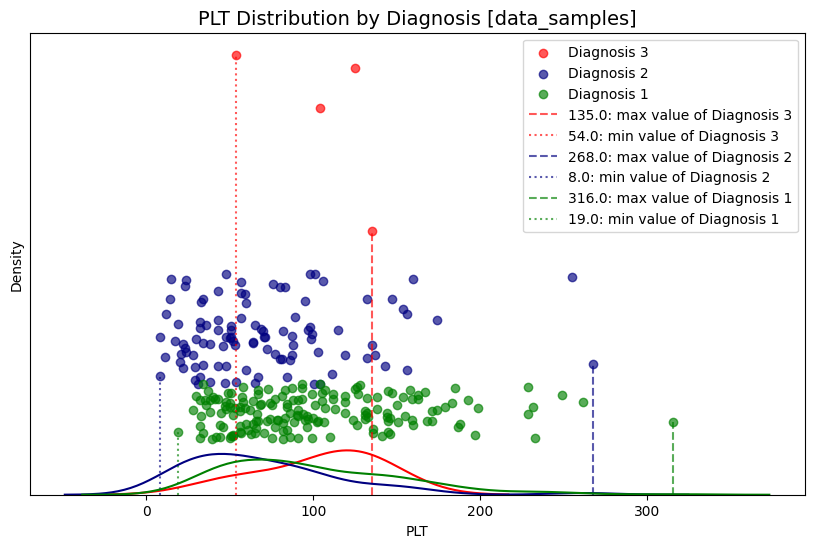

In [34]:
distribution_plot(df_samples, 'PLT', data_name = '[data_samples]')

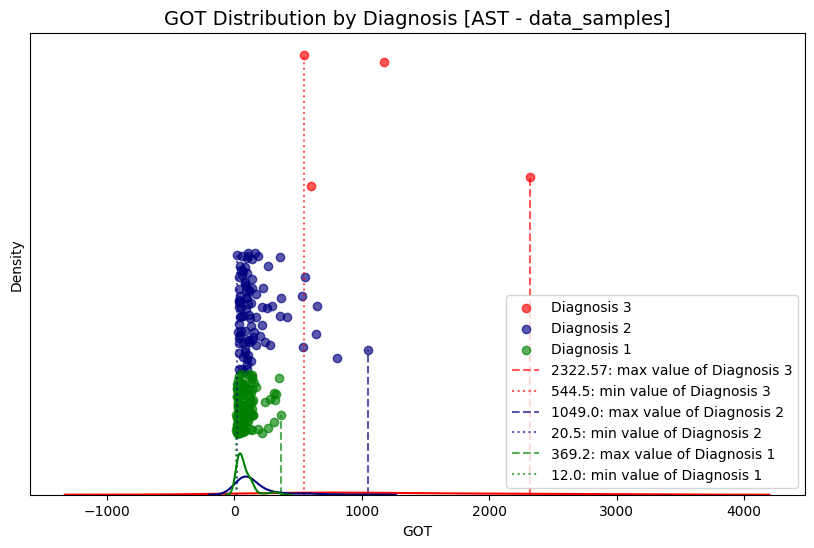

In [35]:
distribution_plot(df_samples, 'GOT', data_name = '[AST - data_samples]')

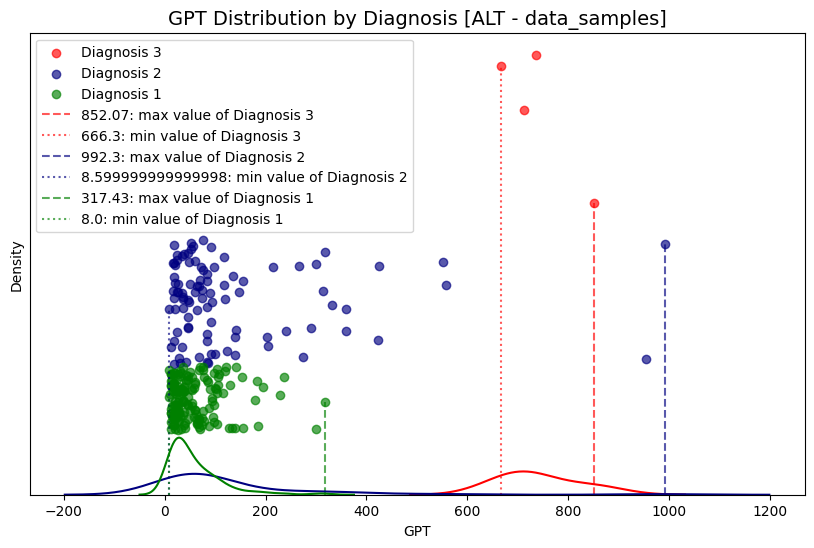

In [36]:
distribution_plot(df_samples, 'GPT', data_name = '[ALT - data_samples]')

In [42]:
df_samples

,Gende,Diagnosis,day of symtoms,GOT,GPT,RBC,WBC,PLT,HCT,NS1,IgG,IgM,bleeding,bleeding place,Vomiting,headache,bodyache
0,1,2,5,292.4,240.2,4.890,1.39,46.00,0.440,1.0,1.0,1.0,1,2,0.0,1,1
1,0,1,4,68.4,97.3,4.250,2.40,79.00,0.371,1.0,0.0,0.0,0,0,0.0,1,1
4,0,2,6,20.5,12.3,4.944,4.20,38.01,0.440,1.0,0.0,0.0,1,2,0.0,1,1
6,1,1,5,63.3,32.0,4.900,4.10,67.00,0.470,1.0,0.0,0.0,0,0,0.0,1,1
7,0,1,3,75.2,46.8,4.590,2.44,146.00,0.392,1.0,0.0,0.0,0,0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0,1,5,123.9,57.5,4.608,2.99,34.85,0.400,1.0,0.0,0.0,0,0,0.0,1,1
275,1,1,2,22.6,14.6,4.300,3.65,138.00,0.382,1.0,0.0,0.0,0,0,0.0,1,1
276,0,1,5,77.5,59.9,3.390,3.08,141.00,0.293,1.0,0.0,0.0,0,0,0.0,1,1
277,0,1,6,129.8,75.9,4.430,2.90,61.00,0.365,1.0,0.0,0.0,0,0,0.0,1,1
